In [62]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import skimage
from skimage.transform import resize
import cv2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.layers import Activation, Dense
import pandas as pd
import matplotlib.pyplot as plt # untuk menampilkan gambar
import seaborn as sns # untuk menampilkan diagram batang
from tensorflow import keras
import pathlib
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

print(tf.__version__)

2.6.0


----------------------------------데이터 로드----------------------------------

- inceptionV3 모델은 최소 크기가 75x75 이기 때문에
- 모든 데이터를 75 75 로 고정해서 불러옴,
  - asl(a to z ,space, del, nothing, total 29 class), number(0~9, unknown, total 11 class) , asl+ number 데이터 셋 총 3개 

In [94]:
PATH3 = "C:\\Users\\HP\\Desktop\\Project\\data\\data"
file_path3 = pathlib.Path(PATH3)
train_dir = os.path.join(file_path3)

BATCH_SIZE = 64
IMG_SIZE = (75, 75)
#train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

#valid data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
class_name = len(class_names)
print(class_names)

Found 99000 files belonging to 38 classes.
Using 79200 files for training.
Found 99000 files belonging to 38 classes.
Using 19800 files for validation.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'space']


-------------------------VGG16, mobilenet, inception 학습-------------------------

In [66]:
img_shape = (75,75, 3)

VGG16_MODEL = tf.keras.applications.vgg16.VGG16(input_shape = img_shape,
                                         include_top = False,
                                         weights = 'imagenet')
VGG16_MODEL.trainable=False

# flatten이 없음 ( globalaveragepooling으로 대체 ) #  ==> 가중치가 필요없음
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   

# FFNN의 가중치는 학습됨
prediction_layer = tf.keras.layers.Dense(class_name, activation ='softmax')

# model : vgg16이 갖고있는 가중치 + FFNN 가중치로 학습
model_VGG16 = tf.keras.Sequential([
    VGG16_MODEL,
    global_average_layer,
    prediction_layer
])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/model_VGG16.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

# 모델 컴파일
model_VGG16.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 참고: gpu사용
with tf.device('/device:GPU:0'):
    epochs=15
    history_VGG16 = model_VGG16.fit(train_ds_als, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds_als),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/15
1088/1088 [==============================] - 51s 47ms/step - loss: 1.0990 - accuracy: 0.7923 - val_loss: 0.2163 - val_accuracy: 0.9453
Epoch 2/15
1088/1088 [==============================] - 50s 46ms/step - loss: 0.1232 - accuracy: 0.9647 - val_loss: 0.0495 - val_accuracy: 0.9922
Epoch 3/15
1088/1088 [==============================] - 51s 46ms/step - loss: 0.0695 - accuracy: 0.9812 - val_loss: 0.0367 - val_accuracy: 1.0000
Epoch 4/15
1088/1088 [==============================] - 50s 46ms/step - loss: 0.0488 - accuracy: 0.9868 - val_loss: 0.0649 - val_accuracy: 0.9766
Epoch 5/15
1088/1088 [==============================] - 50s 46ms/step - loss: 0.0392 - accuracy: 0.9893 - val_loss: 0.1080 - val_accuracy: 0.9766
Epoch 6/15
1088/1088 [==============================] - 50s 46ms/step - loss: 0.0323 - accuracy: 0.9909 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 7/15
1088/1088 [==============================] - 51s 47ms/step - loss: 0.0270 - accuracy: 0.9924 - val_loss: 0.0306 -

<Figure size 864x288 with 0 Axes>

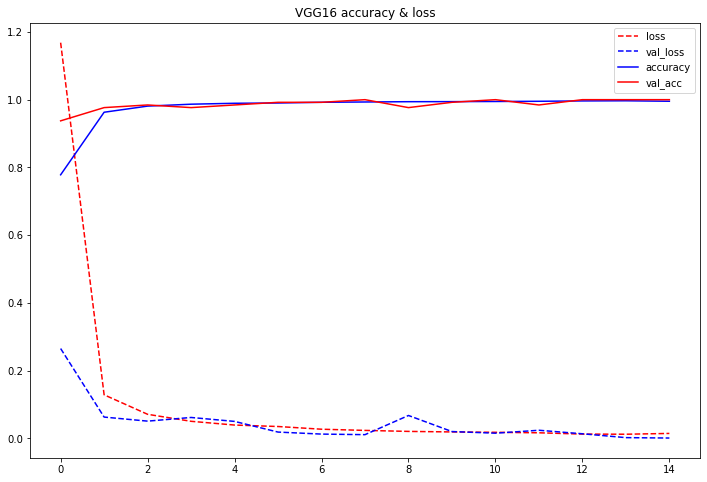

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.figure(figsize=(12,8))
plt.title('VGG16 accuracy & loss')
plt.plot(history_VGG16.history['loss'],'--',c='red')
plt.plot(history_VGG16.history['val_loss'],'--',c='blue')
plt.plot(history_VGG16.history['accuracy'],c='blue')
plt.plot(history_VGG16.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

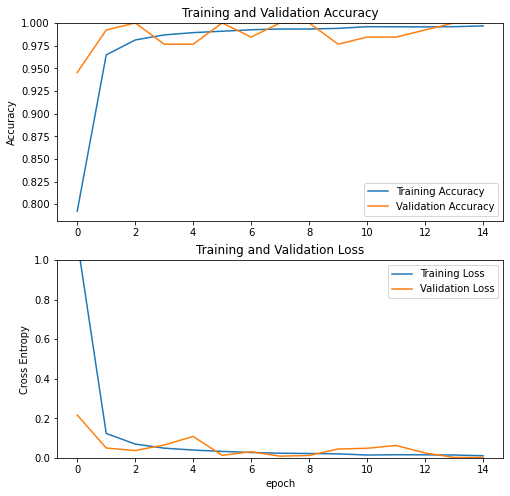

In [68]:
acc = history_VGG16.history['accuracy']
val_acc = history_VGG16.history['val_accuracy']

loss = history_VGG16.history['loss']
val_loss = history_VGG16.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [70]:
model_MobileNet = tf.keras.applications.MobileNetV2(input_shape = img_shape,
                                         include_top = False,
                                         weights = 'imagenet')
model_MobileNet.trainable=False

# flatten이 없음 ( globalaveragepooling으로 대체 ) #  ==> 가중치가 필요없음
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   

prediction_layer = tf.keras.layers.Dense(class_name_als, activation ='softmax')

model_MobileNet = tf.keras.Sequential([
    model_MobileNet,
    global_average_layer,
    prediction_layer
])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/model_MobileNetV2.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

# 모델 컴파일
model_MobileNet.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 참고: gpu사용
with tf.device('/device:GPU:0'):
    epochs=15
    history_MobileNet = model_MobileNet.fit(train_ds_als, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds_als),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])  


Epoch 1/15
1088/1088 [==============================] - 31s 26ms/step - loss: 1.5829 - accuracy: 0.5366 - val_loss: 1.2232 - val_accuracy: 0.6875
Epoch 2/15


C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1088/1088 [==============================] - 27s 24ms/step - loss: 0.9787 - accuracy: 0.7030 - val_loss: 0.8710 - val_accuracy: 0.7109
Epoch 3/15
1088/1088 [==============================] - 27s 25ms/step - loss: 0.8158 - accuracy: 0.7495 - val_loss: 0.7504 - val_accuracy: 0.7656
Epoch 4/15
1088/1088 [==============================] - 27s 24ms/step - loss: 0.7278 - accuracy: 0.7743 - val_loss: 0.7489 - val_accuracy: 0.8047
Epoch 5/15
1088/1088 [==============================] - 28s 26ms/step - loss: 0.6684 - accuracy: 0.7906 - val_loss: 0.6428 - val_accuracy: 0.7812
Epoch 6/15
1088/1088 [==============================] - 28s 26ms/step - loss: 0.6170 - accuracy: 0.8050 - val_loss: 0.8041 - val_accuracy: 0.7891
Epoch 7/15
1088/1088 [==============================] - 28s 26ms/step - loss: 0.5871 - accuracy: 0.8136 - val_loss: 0.6012 - val_accuracy: 0.8359
Epoch 8/15
1088/1088 [==============================] - 27s 25ms/step - loss: 0.5558 - accuracy: 0.8240 - val_loss: 0.6556 - val_accura

<Figure size 864x288 with 0 Axes>

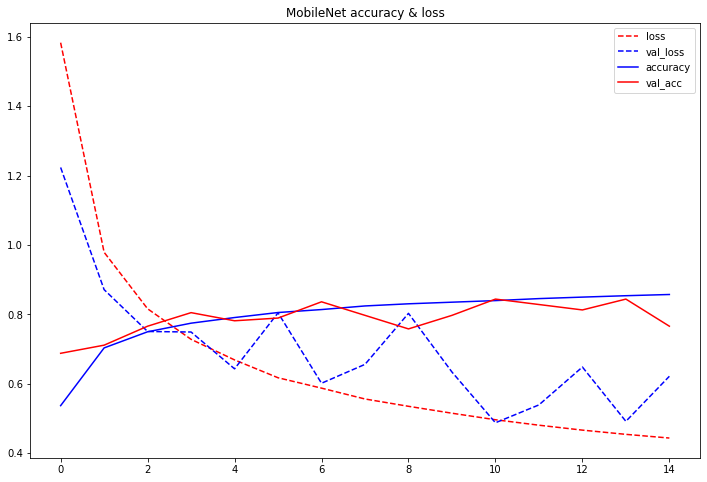

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.figure(figsize=(12,8))
plt.title('MobileNet accuracy & loss')
plt.plot(history_MobileNet.history['loss'],'--',c='red')
plt.plot(history_MobileNet.history['val_loss'],'--',c='blue')
plt.plot(history_MobileNet.history['accuracy'],c='blue')
plt.plot(history_MobileNet.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

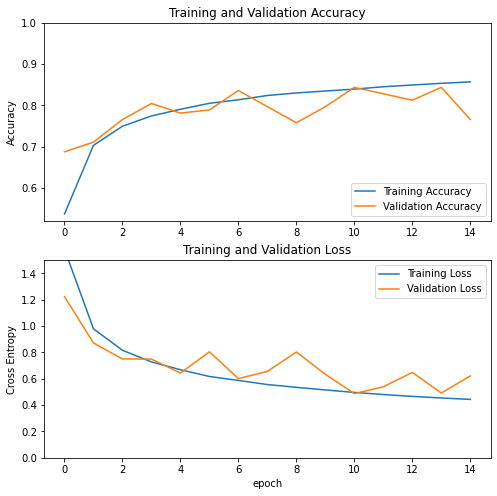

In [73]:
acc = history_MobileNet.history['accuracy']
val_acc = history_MobileNet.history['val_accuracy']

loss = history_MobileNet.history['loss']
val_loss = history_MobileNet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [78]:
img_shape = (75,75, 3)

model_inception_V3 = tf.keras.applications.InceptionV3(input_shape = img_shape,
                                         include_top = False,
                                         weights = 'imagenet')
model_MobileNet.trainable=False

# flatten이 없음 ( globalaveragepooling으로 대체 ) #  ==> 가중치가 필요없음
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   

prediction_layer = tf.keras.layers.Dense(class_name_als, activation ='softmax')

model_inception_V3 = tf.keras.Sequential([
    model_inception_V3,
    global_average_layer,
    prediction_layer
])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/model_inception_V3.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

# 모델 컴파일
model_inception_V3.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 참고: gpu사용
with tf.device('/device:GPU:0'):
    epochs=15
    history_inception_V3 = model_inception_V3.fit(train_ds_als, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds_als),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/15
1088/1088 [==============================] - 111s 97ms/step - loss: 0.3308 - accuracy: 0.9149 - val_loss: 0.1895 - val_accuracy: 0.9531
Epoch 2/15
1088/1088 [==============================] - 104s 95ms/step - loss: 0.0446 - accuracy: 0.9890 - val_loss: 0.1060 - val_accuracy: 0.9766
Epoch 3/15
1088/1088 [==============================] - 103s 95ms/step - loss: 0.0702 - accuracy: 0.9834 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/15
1088/1088 [==============================] - 105s 96ms/step - loss: 0.0221 - accuracy: 0.9943 - val_loss: 0.4634 - val_accuracy: 0.9297
Epoch 5/15
1088/1088 [==============================] - 104s 95ms/step - loss: 0.0593 - accuracy: 0.9861 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/15
1088/1088 [==============================] - 103s 95ms/step - loss: 0.0209 - accuracy: 0.9946 - val_loss: 0.1228 - val_accuracy: 0.9766
Epoch 7/15
1088/1088 [==============================] - 104s 96ms/step - loss: 0.0139 - accuracy: 0.9966 - val_loss: 0

<Figure size 864x288 with 0 Axes>

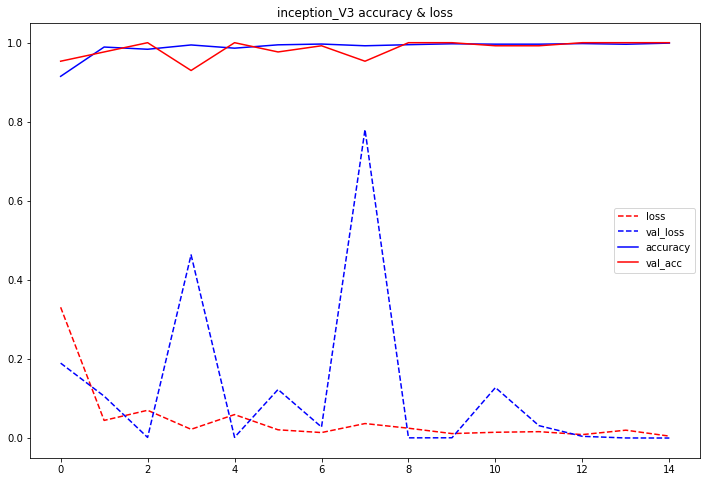

In [79]:
plt.figure(figsize=(12,4))
plt.figure(figsize=(12,8))
plt.title('inception_V3 accuracy & loss')
plt.plot(history_inception_V3.history['loss'],'--',c='red')
plt.plot(history_inception_V3.history['val_loss'],'--',c='blue')
plt.plot(history_inception_V3.history['accuracy'],c='blue')
plt.plot(history_inception_V3.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

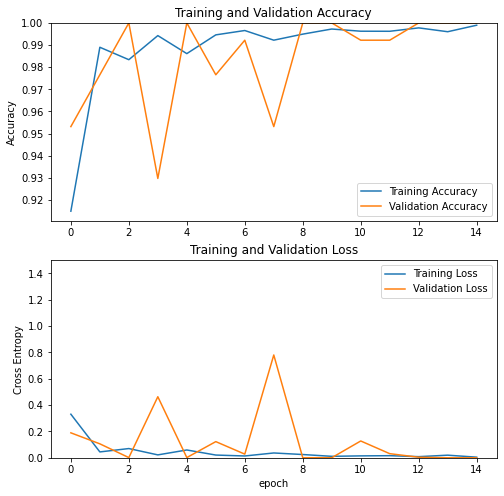

In [80]:
acc = history_inception_V3.history['accuracy']
val_acc = history_inception_V3.history['val_accuracy']

loss = history_inception_V3.history['loss']
val_loss = history_inception_V3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [81]:
test_all_label=[]; test_all_image=[]
for test_img, test_label in val_ds_als:
    test_all_label.extend(test_label.numpy())
    test_all_image.extend(test_img.numpy())
np.shape(test_all_label), np.shape(test_all_image)

((17400,), (17400, 75, 75, 3))

In [82]:
model_VGG16.predict(test_all_image[0].reshape(1,75,75,3),test_all_label[0]),
model_MobileNet.predict(test_all_image[0].reshape(1,75,75,3),test_all_label[0]),
model_inception_V3.predict(test_all_image[0].reshape(1,75,75,3),test_all_label[0])

array([[1.3660535e-14, 7.8510309e-09, 1.8495445e-09, 3.1298400e-10,
        7.2678814e-11, 1.8482096e-11, 3.6841604e-07, 9.9999952e-01,
        3.8505546e-10, 4.2977558e-08, 8.7350259e-11, 4.0348402e-13,
        2.0478810e-12, 4.1389289e-10, 7.5003656e-14, 2.5001876e-08,
        5.1644502e-09, 4.5070357e-11, 5.3518716e-14, 1.0391217e-14,
        6.1406229e-14, 3.2201734e-11, 7.0528222e-11, 1.5028002e-13,
        9.6776432e-12, 2.9487619e-09, 3.0369346e-08, 4.0821138e-09,
        1.1543156e-09]], dtype=float32)

In [83]:
from tqdm import tqdm
result_v=[]
result_m=[]
result_i=[]
with tf.device('/device:GPU:0'):
    for img in tqdm(test_all_image):
        
        softmax_v=model_VGG16.predict(img.reshape(1,75,75,3))
        result_v.append(np.argmax(softmax_v))
        
        softmax_m=model_MobileNet.predict(img.reshape(1,75,75,3))
        result_m.append(np.argmax(softmax_m))
        
        softmax_i = model_inception_V3.predict(img.reshape(1,75,75,3))
        result_i.append(np.argmax(softmax_i))


100%|████████████████████████████████████████████████████████████████████████████| 17400/17400 [39:50<00:00,  7.28it/s]


Text(114.0, 0.5, 'true label')

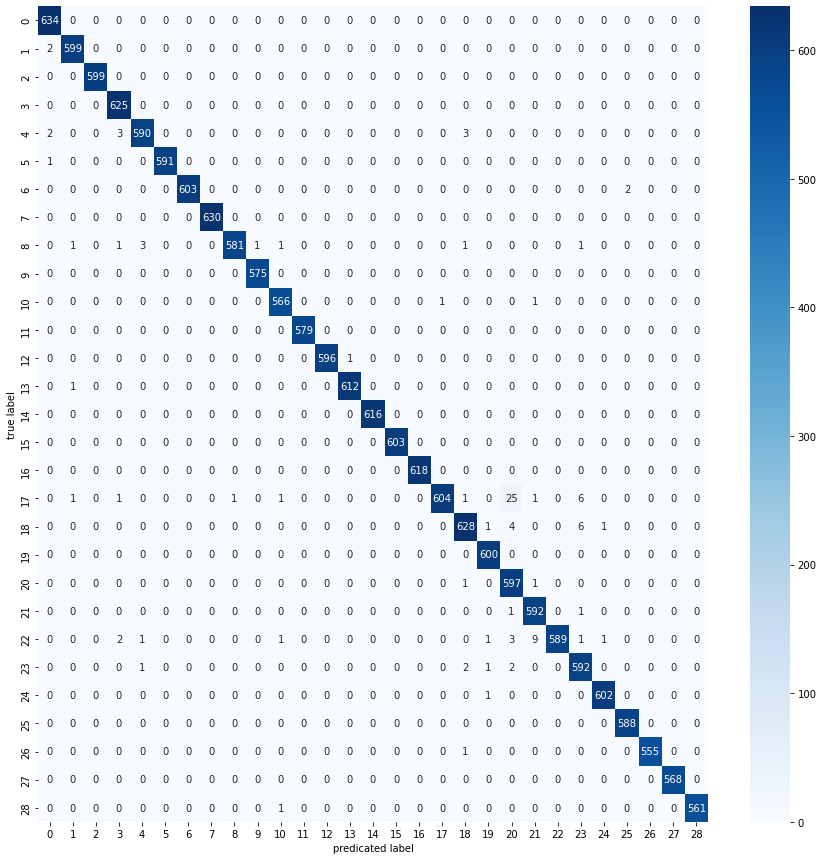

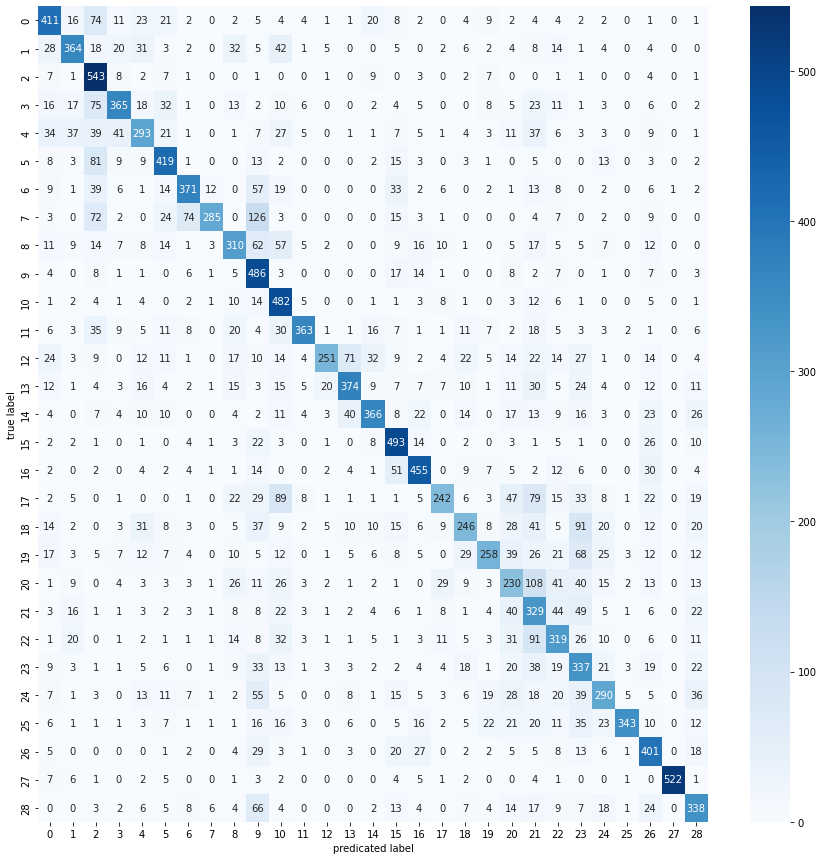

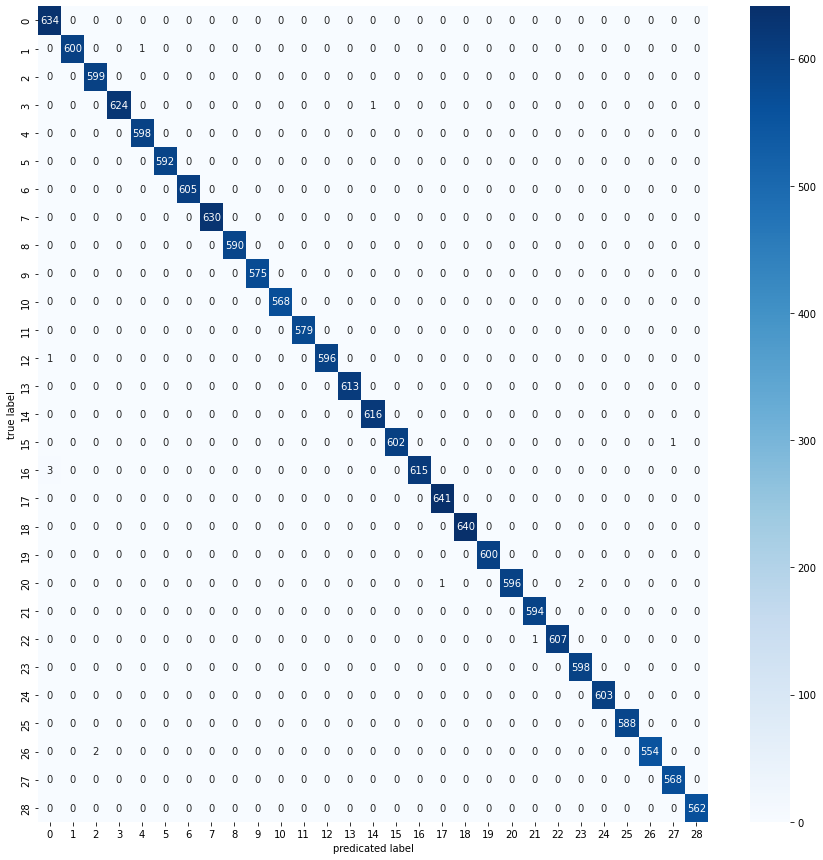

In [85]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


#혼돈행렬만들기

plt.figure(figsize=(15,15))
cm=confusion_matrix(test_all_label, result_v)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

plt.figure(figsize=(15,15))
cm=confusion_matrix(test_all_label, result_m)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

plt.figure(figsize=(15,15))
cm=confusion_matrix(test_all_label, result_i)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

In [98]:
import keras
import glob

tmp = glob.glob('.\\asl\\test\\test\\*.jpg')

# True_name = tmp[0].split('\\')[4].split('.')[0]
# img = keras.preprocessing.image.load_img(tmp[0], target_size=(75,75))
# #plt.imshow(img)
# plt.figure(figsize=(len(tmp), len(tmp)))
# ax = plt.subplot(3, 3, i + 1)
# plt.imshow(img)
# plt.axis("off")
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# predictions_v = model_VGG16.predict(img_array)
# predictions_m = model_MobileNet.predict(img_array)
# predictions_i = model_inception_V3.predict(img_array)

# score_v = tf.nn.softmax(predictions_v[0])
# score_m = tf.nn.softmax(predictions_m[0])
# score_i = tf.nn.softmax(predictions_i[0])


# print(
#     "(VGG16_MODEL) pred :{}  {:.2f} percent confidence. True : {}"
#     .format(class_names[np.argmax(score_v)], 100 * np.max(score_v), True_name),'\n',
#     "(VGG16_MODEL) pred :{}  {:.2f} percent confidence. True : {}"
#     .format(class_names[np.argmax(score_m)], 100 * np.max(score_v), True_name),'\n',
#     "(VGG16_MODEL) pred :{}  {:.2f} percent confidence. True : {}"
#     .format(class_names[np.argmax(score_i)], 100 * np.max(score_v), True_name),'\n')



for i in range(len(tmp)):
    True_name = tmp[i].split('\\')[4].split('.')[0]
    img = keras.preprocessing.image.load_img(tmp[i], target_size=(75,75))
    #plt.imshow(img)
    #plt.figure(figsize=(len(tmp), len(tmp)))
    #ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(img)
    #plt.axis("off")
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions_v = model_VGG16.predict(img_array)
    predictions_m = model_MobileNet.predict(img_array)
    predictions_i = model_inception_V3.predict(img_array)

    score_v = tf.nn.softmax(predictions_v[0])
    score_m = tf.nn.softmax(predictions_m[0])
    score_i = tf.nn.softmax(predictions_i[0])


    print(
        "(VGG16_MODEL) pred :{}  {:.2f} percent confidence. True : {}"
        .format(class_names[np.argmax(score_v)+10], 100 * np.max(score_v), True_name),'\n',
        "(VGG16_MODEL) pred :{}  {:.2f} percent confidence. True : {}"
        .format(class_names[np.argmax(score_m)+10], 100 * np.max(score_v), True_name),'\n',
        "(VGG16_MODEL) pred :{}  {:.2f} percent confidence. True : {}"
        .format(class_names[np.argmax(score_i)+10], 100 * np.max(score_v), True_name),'\n')
    


(VGG16_MODEL) pred :A  6.84 percent confidence. True : A_test 
 (VGG16_MODEL) pred :A  6.84 percent confidence. True : A_test 
 (VGG16_MODEL) pred :A  6.84 percent confidence. True : A_test 

(VGG16_MODEL) pred :B  6.84 percent confidence. True : B_test 
 (VGG16_MODEL) pred :B  6.84 percent confidence. True : B_test 
 (VGG16_MODEL) pred :B  6.84 percent confidence. True : B_test 

(VGG16_MODEL) pred :C  6.84 percent confidence. True : C_test 
 (VGG16_MODEL) pred :C  6.84 percent confidence. True : C_test 
 (VGG16_MODEL) pred :C  6.84 percent confidence. True : C_test 

(VGG16_MODEL) pred :D  6.84 percent confidence. True : D_test 
 (VGG16_MODEL) pred :D  6.84 percent confidence. True : D_test 
 (VGG16_MODEL) pred :D  6.84 percent confidence. True : D_test 

(VGG16_MODEL) pred :E  6.84 percent confidence. True : E_test 
 (VGG16_MODEL) pred :E  6.84 percent confidence. True : E_test 
 (VGG16_MODEL) pred :E  6.84 percent confidence. True : E_test 

(VGG16_MODEL) pred :F  6.84 percent conf

IndexError: list index out of range

----------------------------------------alphabet mnist 데이터셋으로도 확인----------

<AxesSubplot:ylabel='count'>

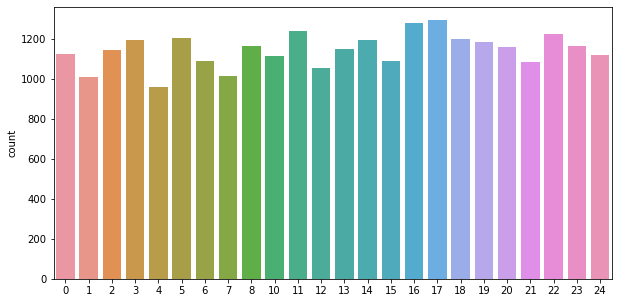

In [78]:

# # melihat jumlah data tiap kelas kelas 
# plt.figure(figsize = (10,5))
# sns.countplot(x =labels)

In [79]:
# # menghapus kolom label pada data training, karena kolom label sebelumnya sudah disimpan di variable labels
# train.drop('label', axis = 1, inplace = True)

In [80]:
# # menjadikan data train menjadi 1 array besar yang terdiri dari tiap data training
# images = train.values
# images = np.array([np.reshape(i, (28, 28)) for i in images])
# images = np.array([i.flatten() for i in images])

In [82]:
# # import data label yang biner. karena kelas yang ingin kita predisksi adalah integer value
# from sklearn.preprocessing import LabelBinarizer
# label_binrizer = LabelBinarizer()
# labels = label_binrizer.fit_transform(labels)

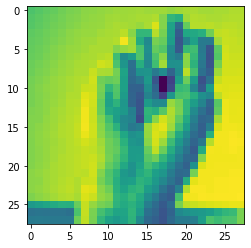

In [83]:
# # contoh data gambar isyarat train data ke-1 
# plt.imshow(images[4].reshape(28,28))

In [84]:
# # mengubah data training 0.7 dan data testing 0.3
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3, random_state = 101)

In [85]:
# batch_size = 128
# num_classes = 24
# epochs = 50

In [86]:
# # nilai piksel 256. kita bisa normalisasinya sehingga nilainya antara 0 sampai 1
# x_train = x_train / 255
# x_test = x_test / 255

In [87]:
# # mengubah data train menjadi array 
# x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
# x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

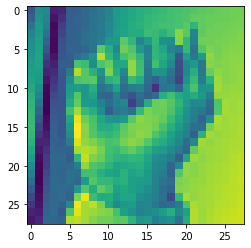

In [88]:
# # contoh data yang sudah dinormalisasi 
# plt.imshow(x_train[0].reshape(28,28))

------------------------------Layer 3개로 작업------------------------------

In [103]:
model = tf.keras.Sequential()

#First Convolution Layer
#kernel_size 3x3
model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', input_shape=(75, 75 ,3)))
model.add(MaxPooling2D(pool_size = (2, 2)))

#Second Convolution Layer
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

#Third Convolution Layer
model.add(Conv2D(256, kernel_size = (3, 3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(1024, activation='sigmoid'))
#출력
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# eksekusi model dengan konfigurasi yang telah diatur
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=epochs, batch_size=batch_size)

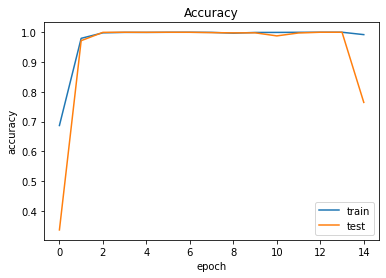

In [133]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

------------------------------Layer 5개로 작업------------------------------

In [105]:
model2 = tf.keras.Sequential()


model2.add(Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape=(75, 75 ,3) ))
model2.add(BatchNormalization())

model2.add(Conv2D(32, kernel_size=(3,3), activation = 'relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, kernel_size=(5,5),strides=2, padding='same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Conv2D(128, kernel_size = 4, activation='relu'))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dropout(0.4))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history2 = model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/50
151/151 [==============================] - 3s 12ms/step - loss: 1.3837 - accuracy: 0.6084 - val_loss: 3.6226 - val_accuracy: 0.0694
Epoch 2/50
151/151 [==============================] - 1s 10ms/step - loss: 0.2327 - accuracy: 0.9384 - val_loss: 3.1598 - val_accuracy: 0.1867
Epoch 3/50
151/151 [==============================] - 1s 10ms/step - loss: 0.0839 - accuracy: 0.9829 - val_loss: 0.6098 - val_accuracy: 0.7937
Epoch 4/50
151/151 [==============================] - 1s 10ms/step - loss: 0.0423 - accuracy: 0.9922 - val_loss: 0.0081 - val_accuracy: 0.9998
Epoch 5/50
151/151 [==============================] - 1s 10ms/step - loss: 0.0269 - accuracy: 0.9951 - val_loss: 9.5308e-04 - val_accuracy: 1.0000
Epoch 6/50
151/151 [==============================] - 2s 10ms/step - loss: 0.0246 - accuracy: 0.9959 - val_loss: 8.5968e-04 - val_accuracy: 0.9999
Epoch 7/50
151/151 [==============================] - 2s 10ms/step - loss: 0.0130 - accuracy: 0.9982 - val_loss: 9.6331e-04 - val_accu

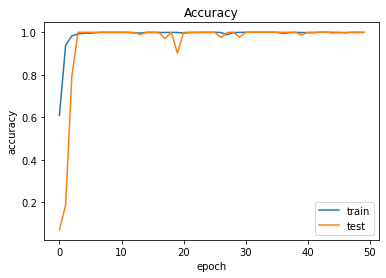

In [106]:

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

In [111]:
test = pd.read_csv('.\\data\\data\\sign_mnist_test.csv')
test_labels = test['label']
test.drop('label', axis = 1, inplace = True)

test_images = test.values
test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
test_images = np.array([i.flatten() for i in test_images])

test_labels = label_binrizer.fit_transform(test_labels)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [117]:
# prediksi data testing
y_pred_3L = model[0].predict(test_images)
y_pred_5L = model2.predict(test_images)

In [118]:
from sklearn.metrics import accuracy_score
# 모델 1, 레이어3개 의 정확도
accuracy_score(test_labels, y_pred_relu.round())

0.8131622978248745

In [119]:
# 모델 2 레이어 5개의 정확도
accuracy_score(test_labels, y_pred_tanh.round())

0.9085331846068042

------------------------------MNIST Dataset  끗------------------------------------

------------------------------ASL Dataset  시작------------------------------------

위 모델에서 input이 안맞아서 다시 만들었습니다! 하단에 간단하게 만들었습니다.

In [23]:
#data autotune
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [24]:
# 3계층 레이어로 알파벳 훈련

model = tf.keras.Sequential()

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (64,64, 3)))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(len(class_names), activation = 'softmax')) # 2개의 출력을 가지는 신경망

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath="./data/model/model_asl_3.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

with tf.device('/device:GPU:0'):

    epochs=15
    history = model.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/15
1088/1088 [==============================] - 87s 79ms/step - loss: 0.7865 - accuracy: 0.7765 - val_loss: 0.0453 - val_accuracy: 0.9766
Epoch 2/15
1088/1088 [==============================] - 86s 79ms/step - loss: 0.0662 - accuracy: 0.9790 - val_loss: 0.0797 - val_accuracy: 0.9844
Epoch 3/15
1088/1088 [==============================] - 85s 78ms/step - loss: 0.0413 - accuracy: 0.9872 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 4/15
1088/1088 [==============================] - 84s 77ms/step - loss: 0.0351 - accuracy: 0.9897 - val_loss: 0.0139 - val_accuracy: 0.9922
Epoch 5/15
1088/1088 [==============================] - 85s 78ms/step - loss: 0.0295 - accuracy: 0.9909 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/15
1088/1088 [==============================] - 85s 78ms/step - loss: 0.0306 - accuracy: 0.9911 - val_loss: 0.0904 - val_accuracy: 0.9844
Epoch 7/15
1088/1088 [==============================] - 85s 77ms/step - loss: 0.0250 - accuracy: 0.9928 - val_loss: 0.0700 -

<Figure size 864x288 with 0 Axes>

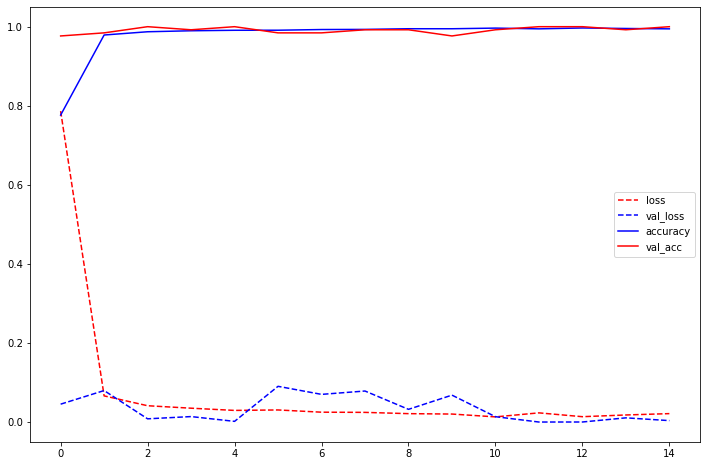

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'--',c='red')
plt.plot(history.history['val_loss'],'--',c='blue')
plt.plot(history.history['accuracy'],c='blue')
plt.plot(history.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

In [28]:
# 5계층으로 훈련

model5 = tf.keras.Sequential()
model5.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', input_shape = (64, 64, 3)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model5.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model5.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model5.add(Flatten())
model5.add(Dense(256))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dense(len(class_names), activation = 'softmax'))

model5.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath="./data/model/model_asl_5.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model5.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

with tf.device('/device:GPU:0'):

    epochs=15
    history5 = model5.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

   

Epoch 1/15
1088/1088 [==============================] - 139s 125ms/step - loss: 0.2749 - accuracy: 0.9278 - val_loss: 0.3871 - val_accuracy: 0.9062
Epoch 2/15
1088/1088 [==============================] - 136s 124ms/step - loss: 0.0214 - accuracy: 0.9949 - val_loss: 0.1618 - val_accuracy: 0.9453
Epoch 3/15
1088/1088 [==============================] - 907s 834ms/step - loss: 0.0121 - accuracy: 0.9969 - val_loss: 1.2627 - val_accuracy: 0.6953
Epoch 4/15
1088/1088 [==============================] - 132s 121ms/step - loss: 0.0176 - accuracy: 0.9950 - val_loss: 0.1789 - val_accuracy: 0.9297
Epoch 5/15
1088/1088 [==============================] - 140s 128ms/step - loss: 0.0080 - accuracy: 0.9980 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 6/15
1088/1088 [==============================] - 142s 130ms/step - loss: 2.3992e-04 - accuracy: 1.0000 - val_loss: 9.5018e-05 - val_accuracy: 1.0000
Epoch 7/15
1088/1088 [==============================] - 144s 132ms/step - loss: 0.0167 - accuracy: 0.995

<Figure size 864x288 with 0 Axes>

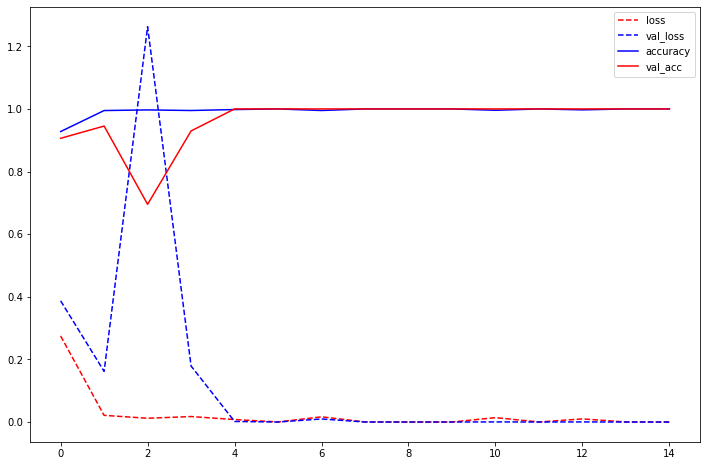

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history5.history['loss'],'--',c='red')
plt.plot(history5.history['val_loss'],'--',c='blue')
plt.plot(history5.history['accuracy'],c='blue')
plt.plot(history5.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

값이 하나 튀는건 아무래도, 논문에서 본것 처럼 혼동이 되는 알파벳 2개가 있어서 그런것 같습니다!

100%|████████████████████████████████████████████████████████████████████████████| 17400/17400 [08:45<00:00, 33.12it/s]


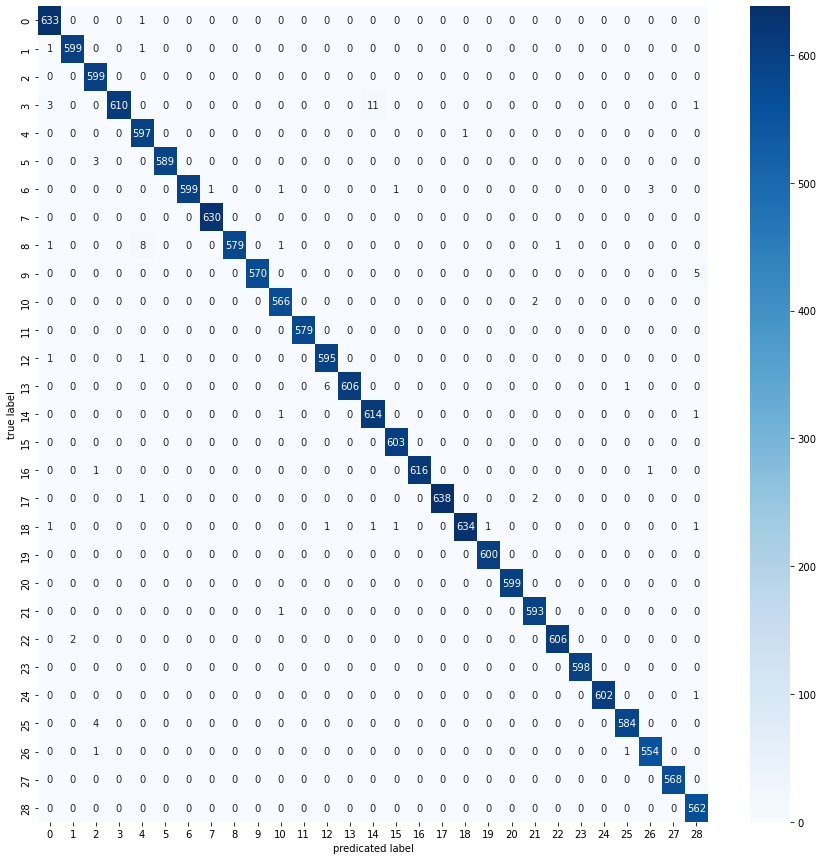

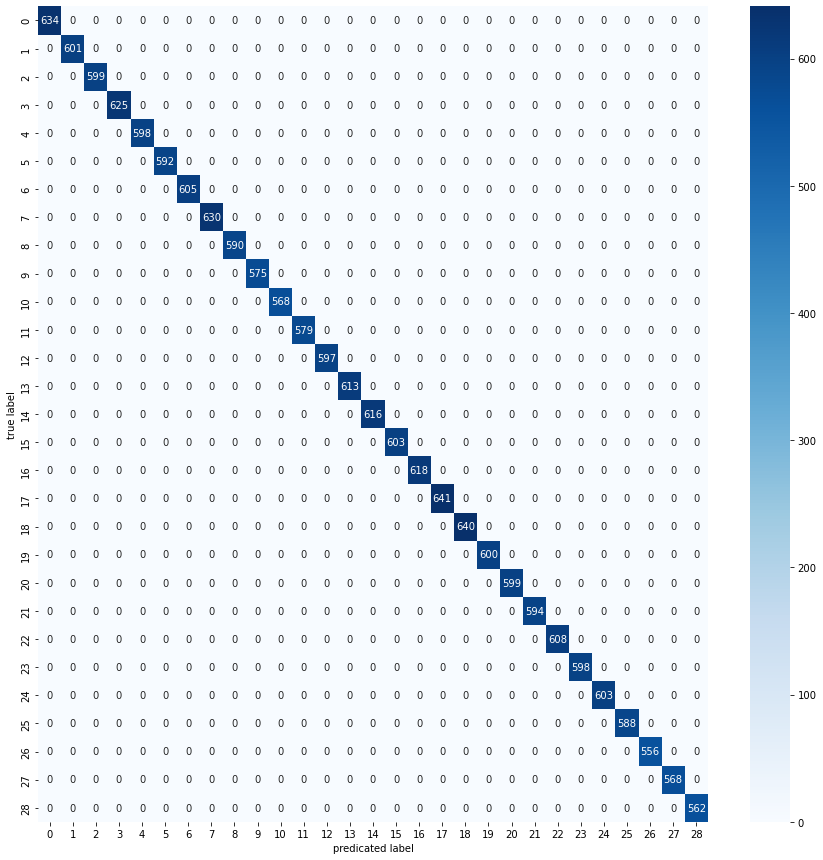

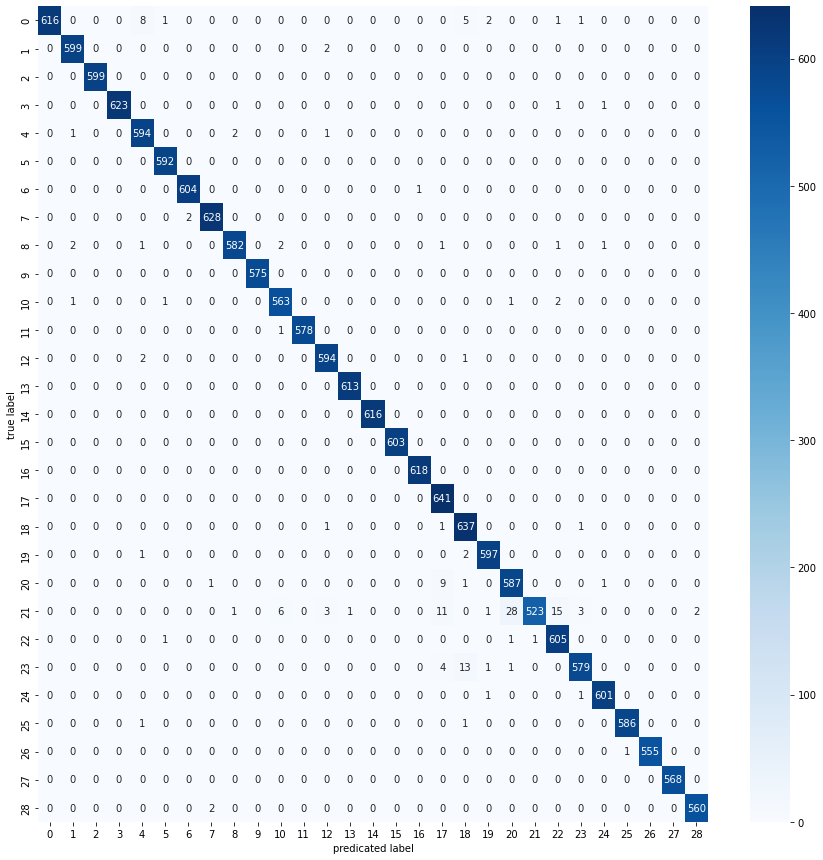

In [40]:
#테스트 데이터의 이미지전처리와 라벨링
test_all_label=[]; test_all_image=[]
for test_img, test_label in val_ds:
    test_all_label.extend(test_label.numpy())
    test_all_image.extend(test_img.numpy())
np.shape(test_all_label), np.shape(test_all_image)

model_VGG16_adam.predict(test_all_image[0].reshape(1,64,64,3),test_all_label[0])
model.predict(test_all_image[0].reshape(1,64,64,3),test_all_label[0])
model5.predict(test_all_image[0].reshape(1,64,64,3),test_all_label[0])

from tqdm import tqdm
result_3=[]
with tf.device('/device:GPU:0'):
    for img in tqdm(test_all_image):
        softmax=model.predict(img.reshape(1,64,64,3))
        result_3.append(np.argmax(softmax))
        
from tqdm import tqdm
result_v=[]
with tf.device('/device:GPU:0'):
    for img in tqdm(test_all_image):
        softmax=model_VGG16_adam.predict(img.reshape(1,64,64,3))
        result_v.append(np.argmax(softmax))
        
from tqdm import tqdm
result_5=[]
with tf.device('/device:GPU:0'):
    for img in tqdm(test_all_image):
        softmax=model5.predict(img.reshape(1,64,64,3))
        result_5.append(np.argmax(softmax))

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#혼돈행렬만들기
plt.figure(figsize=(15,15))
cm=confusion_matrix(test_all_label, result_3)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

plt.figure(figsize=(15,15))
cm=confusion_matrix(test_all_label, result_5)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

plt.figure(figsize=(15,15))
cm=confusion_matrix(test_all_label, result_v)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')
plt.show()

---------------------각 예측값으로 혼동행렬 그리기 끝------------------------------

## 모델 학습 후 시각화

<Figure size 864x288 with 0 Axes>

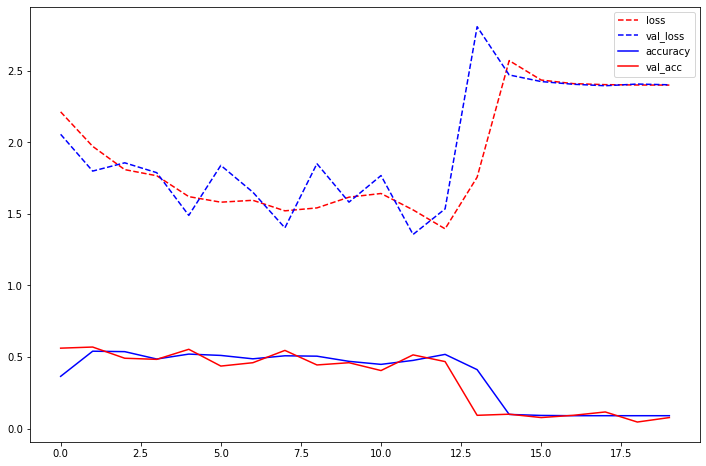

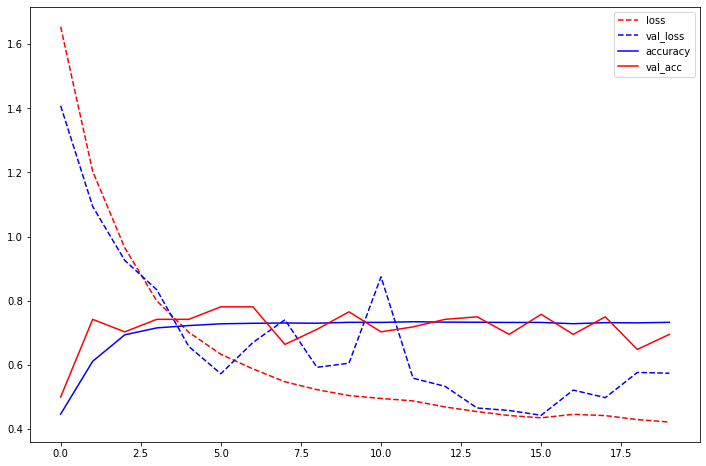

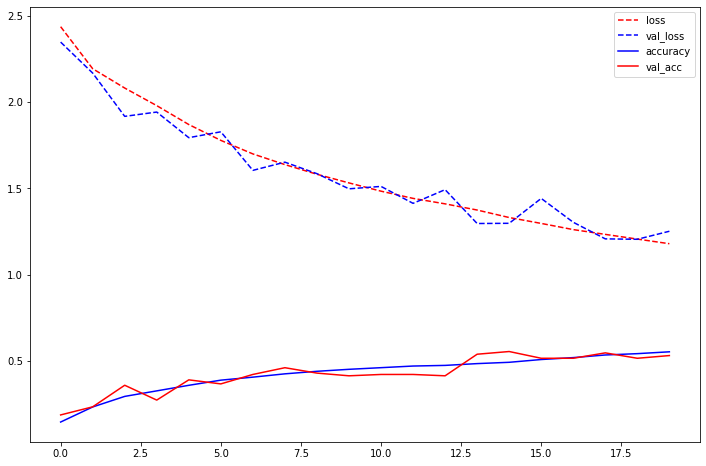

In [44]:
plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history_num_3.history['loss'],'--',c='red')
plt.plot(history_num_3.history['val_loss'],'--',c='blue')
plt.plot(history_num_3.history['accuracy'],c='blue')
plt.plot(history_num_3.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])

plt.figure(figsize=(12,8))
plt.plot(history_num_5.history['loss'],'--',c='red')
plt.plot(history_num_5.history['val_loss'],'--',c='blue')
plt.plot(history_num_5.history['accuracy'],c='blue')
plt.plot(history_num_5.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])

plt.figure(figsize=(12,8))
plt.plot(history_num_v.history['loss'],'--',c='red')
plt.plot(history_num_v.history['val_loss'],'--',c='blue')
plt.plot(history_num_v.history['accuracy'],c='blue')
plt.plot(history_num_v.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

---------------------직접 사진을 찍어서 모델로 예측 연습

(64, 64, 3)
(1, 64, 64, 3)
(model_num_adam), true :7, prediction :J , percent :8.85


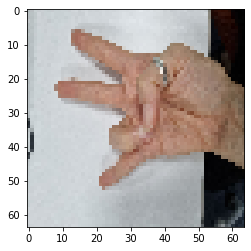

In [104]:
import keras
import glob
import matplotlib.pyplot as plt


tmp = glob.glob(".\\test\\7.jpg")

img = keras.preprocessing.image.load_img(tmp[0], target_size=(64,64))
plt.imshow(img)

img_array = keras.preprocessing.image.img_to_array(img)
print(np.shape(img_array))

img_array = tf.expand_dims(img_array, 0) # Create a batch
print(np.shape(img_array))

predictions = model_num_adam.predict(img_array)

score = tf.nn.softmax(predictions[0])
score


print("(model_num_adam), true :{}, prediction :{} , percent :{:.2f}".format(7, class_names[np.argmax(score)], 100 * np.max(score)))


